In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import random
from PIL import Image
import shutil
from glob import glob

In [17]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()                   
    ])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

In [ ]:
class CatDogDataset(Dataset):
    def __init__(self, folder, transform=None):
        self.file_list = glob(os.path.join(folder, "*", "*.jpg"))
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        while True:
            img_path = self.file_list[idx]
            folder_name = os.path.basename(os.path.dirname(img_path))
            label = 0 if folder_name == "Cat" else 1

            try:
                img=Image.open(img_path).convert("RGB")
            except:
                idx = (idx + 1) % len(self.file_list)
                continue

            if self.transform:
                img = self.transform(img)

            return img, torch.tensor(label)


In [41]:
train_dataset = CatDogDataset("../data/PetImages/data_train", train_transform)
val_dataset = CatDogDataset("../data/PetImages/data_val", val_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))


Train batches: 750
Val batches: 282


In [42]:
images, labels = next(iter(train_loader))
print("Batch shape:", images.shape)
print("Labels:", labels[:10])

Batch shape: torch.Size([32, 3, 224, 224])
Labels: tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 1])


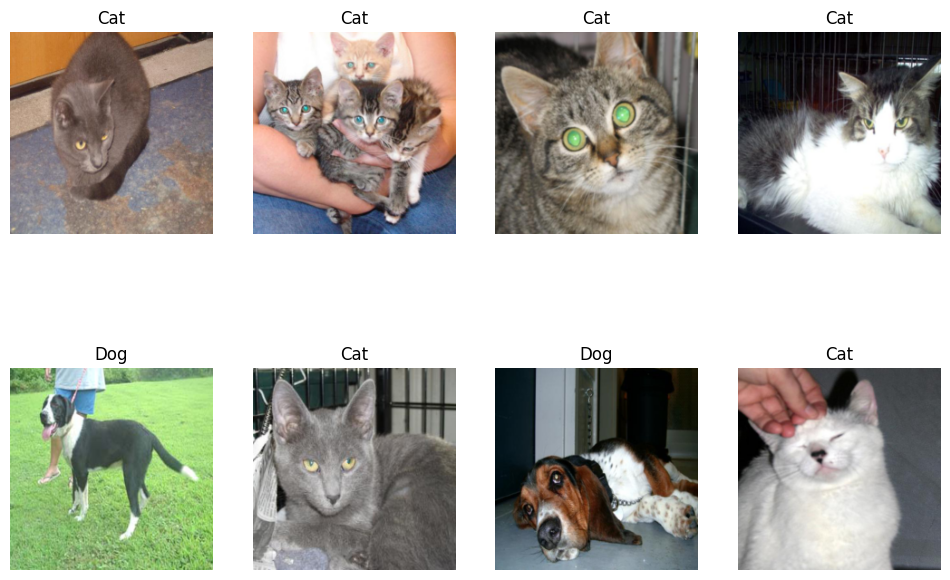

In [43]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F


label_map = {0: "Cat", 1: "Dog"}  

plt.figure(figsize=(12, 8))

for i in range(8):  
    img = images[i]
    label = labels[i].item()
    
   
    img = F.to_pil_image(img)

    plt.subplot(2, 4, i+1)
    plt.imshow(img)
    plt.title(label_map[label])
    plt.axis("off")

plt.show()


In [44]:
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0,3),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [45]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = MyCNN().to(device)

print(model)

MyCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=100352, out_features=256, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Dropout(p=0, inplace=3)
    (7): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [46]:
criterion = nn.CrossEntropyLoss()
optimezer = optim.Adam(model.parameters(), lr=1e-3)

scaler = GradScaler()

C:\Users\user\AppData\Local\Temp\ipykernel_19432\3517340315.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


In [47]:
from tqdm import tqdm

def train_model(epoch):
    model.train()
    total_loss = 0

    loop = tqdm(train_loader, desc=f"Epoch {epoch} Training") 

    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)

        optimezer.zero_grad()

        with autocast():
            outputs = model(imgs)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimezer)
        scaler.update()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    return total_loss / len(train_loader)

In [48]:
def validate():
    model.eval()
    total = 0
    correct = 0
    val_loss = 0

    with torch.no_grad():
        for imgs, labes in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)

            with autocast():
                outputs = model(imgs)
                loss= criterion(outputs, labels)

            val_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    return val_loss / len(val_loader), acc


In [49]:
best_acc = 0

for epoch in range(1, 11):
    train_loss = train_model(epoch)
    val_loss, val_acc = validate()

    print(f"\nEpoch {epoch} -> TrainLoss: {train_loss:.4f}, "
          f"ValLoss: {val_loss:.4f}, Acc: {val_acc:.4f}")

if  val_acc > best_acc:
    best_acc = val_acc
    torch.save(model.state_dict(), "../model/best_model.pth")
    print("Saved Best Model")

Epoch 1 Training:   0%|          | 0/750 [00:00<?, ?it/s]C:\Users\user\AppData\Local\Temp\ipykernel_19432\3041612817.py:14: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Epoch 1 Training:   3%|▎         | 19/750 [00:15<09:34,  1.27it/s, loss=0.691]c:\Users\user\miniconda3\envs\pytorch\Lib\site-packages\PIL\TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
Epoch 1 Training: 100%|██████████| 750/750 [09:15<00:00,  1.35it/s, loss=0.552]


UnboundLocalError: cannot access local variable 'labels' where it is not associated with a value